# **ADM Homework 5 - USA Airport Flight Analysis**

### Import Dataset and Libraries

In [122]:
!pip install kaggle folium seaborn  python-louvain scipy plotly nbformat tabulate

In [2]:
!kaggle datasets download flashgordon/usa-airport-dataset

Dataset URL: https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset
License(s): CC0-1.0
usa-airport-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [123]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import re
from collections import defaultdict
import folium
import requests
import time
from modules.graph import *
from modules.utils import *
from modules.shortest_path import *
from IPython.display import display
import random
import heapq
from collections import deque
import math
import scipy
from tabulate import tabulate


We unzip the file downloaded from Kaggle and save it to our current working directory.

In [9]:
# Unzip the file we downloaded from kaggle
zip_file_path = 'usa-airport-dataset.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.') # extract files to current working directory

Now we save the data in a CSV file:

In [55]:
df = pd.read_csv('Airports2.csv')
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


# 1. Flight Network Analysis (Q1)

### Data Cleaning

According to the source website https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset, this dataset (with data from the OpenFlights website) contains over 3.5 million US Domestic Flights from 1990 to 2009.

It contains the following features:

1. `Origin_airport`: Three letter airport code of the origin airport  
2. `Destination_airport`: Three letter airport code of the destination airport  
3. `Origin_city`: Origin city name  
4. `Destination_city`: Destination city name  
5. `Passengers`: Number of passengers transported from origin to destination  
6. `Seats`: Number of seats available on flights from origin to destination  
7. `Flights`: Number of flights between origin and destination (multiple records for one month, many with flights > 1)  
8. `Distance`: Distance (to nearest mile) flown between origin and destination  
9. `Fly_date`: The date (yyyymm) of flight  
10. `Origin_population`: Origin city's population as reported by US Census  
11. `Destination_population`: Destination city's population as reported by US Census  
12. `Org_airport_lat`: latitude of the origin airport  
13. `Org_airport_long`: longitude of the origin airport  
14. `Dest_airport_lat`: latitude of the destination airport  
15. `Dest_airport_long`: longitude of the destination airport

Here we can see the shape of the dataset:

In [11]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns {df.shape[1]}')

Number of rows: 3606803
Number of columns 15


Now we look for missing values:

In [12]:
# Look for missing values
missing_counts = df.isnull().sum()
missing_counts

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

There are almost seven thousand missing values in all the coordinate columns. We can use the Nomatim API from `https://nominatim.openstreetmap.org/search` to fill these values:

In [13]:
fill_na_coordinates(df)

In [6]:
df.isnull().sum()

Origin_airport            0
Destination_airport       0
Origin_city               0
Destination_city          0
Passengers                0
Seats                     0
Flights                   0
Distance                  0
Fly_date                  0
Origin_population         0
Destination_population    0
Org_airport_lat           0
Org_airport_long          0
Dest_airport_lat          0
Dest_airport_long         0
dtype: int64

Next, we do a data type integrity check. `Passengers`, `Seats`, `Flights`, `Origin_population`, `Destination_population` should be integers, `Distance` and the coordinates columns should be numeric (float or integer), and `Fly_date` should be in date format.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB


All data types seem correct, but it would be good to convert the `Fly_date` column type from object to datetime. The dataset description specified that dates should be in yyyymm format, however we can see from the output that there are three date entries. We could check to see if one of them indicates days.

In [56]:
# Check if day>12 or month>12 somewhere to figure out date format
for date in df['Fly_date']:
    year, entry2, entry3 = map(int, date.split('-'))
    if entry2>12:
        print('Format is yyyy-dd-mm')
    if entry3>13:
        print('Format is yyyy-mm-dd')

# See if the third date entry is different from '01' somewhere
for date in df['Fly_date']:
    year, entry2, entry3 = map(str, date.split('-'))
    if entry3 != '01':
        print(date)

Since neither the second nor third entry in the date contain values above 13, but all the dates contain '01' at the end, it could be that the '01' is just a placeholder for the day, but doesn't carry any special meaning. For this reason, we decide to treat `Fly_date` values as months, and remove the placeholder.

In [57]:
df['Fly_date'] = df['Fly_date'].apply(lambda x: re.sub(r'-01$', '', x))

Now we convert the column to datetime, with period 'M' for month.

In [58]:
df['Fly_date'] = pd.to_datetime(df['Fly_date'], format='%Y-%m').dt.to_period('M')

We can verify if there are any duplicates, and if there are, create a copy `df2` of the dataset without duplicate rows.

In [59]:
# Count number of duplicates
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

# Save a copy of the dataset without the duplicates
df2 = df.drop_duplicates()
print(f'Number of rows after removing duplicates: {df2.shape[0]}')

Number of duplicate rows: 41753
Number of rows after removing duplicates: 3565050


Now we check if the latitude and longitude data is valid. Latitude values, if not missing, should be in the interval [-90,90], and longitude values in the interval [-180, 180].

In [12]:
# Check if not missing latitude values are in [-90, 90]
print(f' Mininum latitude: {df['Org_airport_lat'].min()}, Maximum latitude: {df['Org_airport_lat'].max()}')

# Check if not missing longitude values are in [-180, 180]
print(f' Mininum longitude: {df['Org_airport_long'].min()}, Maximum longitude: {df['Org_airport_long'].max()}')

 Mininum latitude: 19.721399307251, Maximum latitude: 64.83750153
 Mininum longitude: -157.921997070312, Maximum longitude: -68.8281021118164


Additionally, we would like the number of passengers to not exceed the number of seats:

In [13]:
# Check if number of passangers is greater than number of seats
print(f'Number of rows for which number of passengers is greater than number of seats: {df[df['Passengers']>df['Seats']].shape[0]}')

Number of rows for which number of passengers is greater than number of seats: 280


There are 280 flights with more passengers than seats, which is a problematic that can happen if there is overbooking. Sometimes, airlines might sell more tickets than there are seats because there could be passangers that cancel or do not show up.

Lastly, we want to make sure that the same airport code is not associated with different cities:

In [60]:
# Group by 'Destination_airport' and count unique values of 'Destination_city' (we want all 1s)
dest_max__num_cities_for_code = max(df2.groupby('Destination_airport')['Destination_city'].nunique())
print(f'Maximum number of cities associated with a destination airport code: {dest_max__num_cities_for_code}')

# Group by 'Origin_airport' and count unique values of 'Origin_city' (we want all 1s)
origin_max__num_cities_for_code = max(df2.groupby('Origin_airport')['Origin_city'].nunique())
print(f'Maximum number of cities associated with an origin airport code: {origin_max__num_cities_for_code}')

Maximum number of cities associated with a destination airport code: 1
Maximum number of cities associated with an origin airport code: 1


Perfect, every airport code only has one associated city.

Next, we calculate the number of self-loops:

In [61]:
self_loops_df = df2[df2['Origin_airport']==df2['Destination_airport']]
self_loop_count = self_loops_df.shape[0]
print(f'Number of self-loops (origin airport = destination airport): {self_loop_count}')

Number of self-loops (origin airport = destination airport): 6068


If we don't want to loose information, we may choose to keep internal flights for now.

We would also like to see if values in the `Seats` column are positive:

In [16]:
print(f'Percentage of positive Seat number values: {round(df2[df2['Seats'] > 0 ].shape[0] / df2.shape[0] *100,2)} %')
print(f'Percentage of fligths with with Seat number 0: {round(df2[df2['Seats']  == 0 ].shape[0] / df2.shape[0] *100,2)} %')

Percentage of positive Seat number values: 91.76 %
Percentage of fligths with with Seat number 0: 8.24 %


Most flights contain a valid number of seats, but 8.24% of flight data have null seat number, which could indicate anomalies or missing data. These rows could also refer to empty or special flights, but the percentage is a bit high for that.

In [17]:
print(f'Number of rows where Seats=0 and Passengers>0: {df2[(df2['Seats']  == 0) & (df2['Passengers'] > 0)].shape[0]}')

Number of rows where Seats=0 and Passengers>0: 10


Since the number of rows with null number of seats and positive number of passengers is very low, when calculating the passenger flows later, we may choose to skip the rows that contain null seats data.

Another problem that might arise is represented by too high seats-to-flights or passengers-to-flights ratios. From a quick Google search (see https://aviex.goflexair.com/flight-school-training-faq/how-many-passengers-can-a-commercial-plane-carry) we found that the maximum seat capacity of a commercial plane is that of the Airbus A380, with 853 passengers. We want to make sure that the seat capacities in the dataset do not exceed that value. From the information provided about the dataset, we can assume that the `Seats` and `Passengers` columns refer to the total counts of those values over the number indicated in the `Flights` column. For this reason, we will verify if the following conditions hold:

$$
\text{Passengers-to-Flights Ratio} = \frac{\min(\text{Passengers, Seats})}{\text{Flights}} < 853
$$

$$
\text{Seats-to-Flights Ratio} = \frac{\text{Seats}}{\text{Flights}} < 853
$$

In [62]:
# Rows with at least one flight
flights_non_zero = df2['Flights'] > 0

# Compute passengers-to-flights ratio
passengers_to_flights = np.minimum(df2[flights_non_zero]['Passengers'], df2[flights_non_zero]['Seats']) / df2[flights_non_zero]['Flights']

# Print findings
print(f'Max value of passengers-to-flights ratio: {np.max(passengers_to_flights)}')
print(f'Number of values of passengers-to-flights ratio above 853: {(passengers_to_flights>853).sum()}')

# Compute seats-to-flights ratio
seats_to_flights = df2[flights_non_zero]['Seats'] / df2[flights_non_zero]['Flights']

# Print findings
print(f'\nMax value of seats-to-flights ratio: {np.max(seats_to_flights)}')
print(f'Number of values of seats-to-flights ratio above 853: {(seats_to_flights>853).sum()}')

Max value of passengers-to-flights ratio: 940.0
Number of values of passengers-to-flights ratio above 853: 1

Max value of seats-to-flights ratio: 15514.0
Number of values of seats-to-flights ratio above 853: 13


Both maxima are too high, indicating that some flights have seat or passenger numbers above the allowed value. There is no straighforward answer for how to address these anomalies. Since passenger numbers are the ones contributing most to meaningful statistics, we prioritize fixing the problem in the passengers-to-flights ratio.

There is just one row with too high passengers-to-flights ratio. Here it is:

In [63]:
anomaly_row = df2[df2['Passengers']/df2['Flights'] == max(passengers_to_flights)]
row_index = df2[df2['Passengers']/df2['Flights'] == np.max(passengers_to_flights)].index[0]
anomaly_row

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
3256852,MKC,IND,"Kansas City, MO","Indianapolis, IN",940,2150,1,446,2000-09,1842924,1531156,39.123199,-94.592796,39.7173,-86.294403


It seems that the value in `Flights` is too low. There could be different potential candidates for the actual, unknown value. We could estimate it by computing the average passengers-to-fligths and seats-to-fligths ratio:

In [64]:
avg_passengers_to_flights = np.mean(passengers_to_flights)
avg_seats_to_flights = np.mean(seats_to_flights)
print(f'Average passengers-to-flights ratio: {avg_passengers_to_flights}')
print(f'Average seats-to-flights ratio: {avg_seats_to_flights}')
print(f'Estimated number of flights, going by average passengers-to-flights ratio: {anomaly_row.iloc[0]['Passengers']/avg_passengers_to_flights}')
print(f'Estimated number of flights, going by average seats-to-flights ratio: {anomaly_row.iloc[0]['Seats']/avg_seats_to_flights}')

SyntaxError: f-string: unmatched '[' (2493676325.py, line 5)

Seeing these results, we make the assumption that the number of flights for the anomaly row is between 13 and 19. We put 16, to be in the middle.

In [65]:
df2.loc[row_index, 'Flights'] = 16
df2[df2['Passengers']/df2['Flights'] == max(passengers_to_flights)]

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long


### Create the Graph

For this first part, to work with the airline graph, we created a directed graph class `CustomDiGraph`, implemented in the `graph.py` module.

Here we initialize the `flight_network` graph, add nodes to it for each airport, and directed edges for flights (from origin airport to destination airport).

In [66]:
flight_network = CustomDiGraph()

In [67]:
# Add all unique airports (origin and destination) as nodes
all_airports = set(df['Origin_airport']).union(set(df['Destination_airport']))
for airport in all_airports:
    flight_network.add_node(airport)

# Add edges to the graph
for idx in range(df2.shape[0]):
    origin = df2['Origin_airport'].iloc[idx]
    destination = df2['Destination_airport'].iloc[idx]
    # If the edge is not there yet, add the edge
    if not flight_network.has_edge(origin, destination):
        flight_network.add_edge(origin, destination)

Here we plot the graph of the USA airports network by using the networkx library (just for visualization purposes). To prevent the graph from being too messy, we did not add labels here.

Text(0.5, 1.0, 'USA Airports Network')

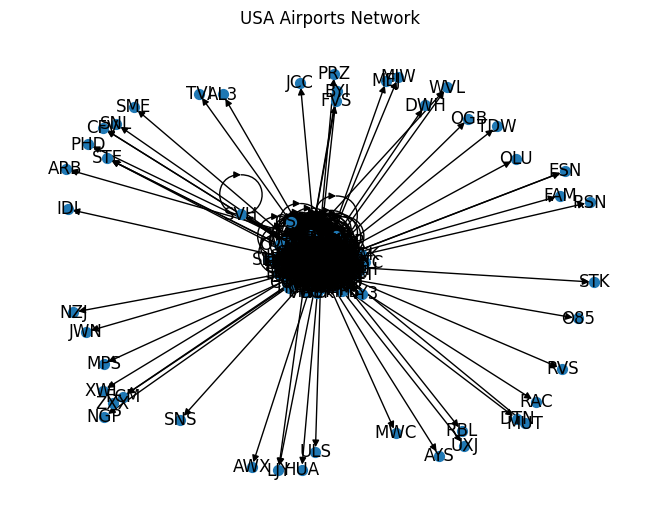

In [80]:
# Plot the graph using NetworkX
G = flight_network.to_networkx_digraph()
pos = nx.spring_layout(G)  # Force-directed
nx.draw(G, pos, with_labels=True,node_size=50,)
plt.title('USA Airports Network')


Here we can check how many of the edges are reciprocated, to see if using a directed graph instead of an undirected graph was the right choice:

In [43]:
# Calculate the number of reciprocated edges
reciprocated_edges = 0
for edge in G.edges():
    # Check if the reverse edge exists (reciprocated)
    if G.has_edge(edge[1], edge[0]):
        reciprocated_edges += 1

# Calculate the percentage of reciprocated edges
if len(G.edges())>0:
    percentage_reciprocated_edges = reciprocated_edges / len(G.edges())*100
    print(f'Percentage of reciprocated edges: {percentage_reciprocated_edges:.2f}%')
else:
    print('No edges in the graph.')

Percentage of reciprocated edges: 74.04%


About 74.04% of the edges are reciprocated, so some nodes only have one-way connections, which is best represented by a directed graph.

### Implement the function ```analyze_graph_features(flight_network)```

Now we implement a function `analyze_graph_features(flight_network)` that takes the `flight_network` as input and computes:

* Number of airports (nodes) and flights (edges) in the graph.
* Density of the (directed) graph: $\frac{E}{n \cdot (n-1)}$
* Calculate in-degree and out-degree values for each airport and visualize them using histograms
* Find airports with degrees higher than the 90th percentile and list them as *hubs*
* Determine if the graph is sparse or dense based on its density

We apply the `analyze_graph_features` function to analyze the graph:

Number of airports (nodes): 727
Number of flights (edges): 36719
Graph Density: 0.0695696492245198
Graph is dense: False
Hubs:
['FWA', 'YIP', 'CHA', 'LIT', 'OMA', 'HOU', 'DAL', 'TUL', 'LAX', 'OAK', 'PIA', 'RNO', 'ATL', 'RDU', 'DFW', 'MIA', 'MSN', 'MKE', 'SYR', 'IAH', 'AUS', 'DSM', 'COS', 'PDX', 'FLL', 'JAX', 'BUF', 'SHV', 'SEA', 'TUS', 'MDW', 'DTW', 'MSP', 'BHM', 'CAE', 'MCO', 'BOS', 'EWR', 'CVG', 'SAN', 'CLT', 'STL', 'PIT', 'ELP', 'JFK', 'SLC', 'SAT', 'PHX', 'IAD', 'LEX', 'GRR', 'MSY', 'MCI', 'LAN', 'LRD', 'LGA', 'ABQ', 'SFO', 'RFD', 'BDL', 'MEM', 'BNA', 'GSP', 'ORD', 'DAY', 'TPA', 'OKC', 'CLE', 'LAS', 'CMH', 'IND', 'TYS', 'BWI', 'PHL', 'ICT', 'SBN', 'GSO', 'TOL']
Degree distributions: 


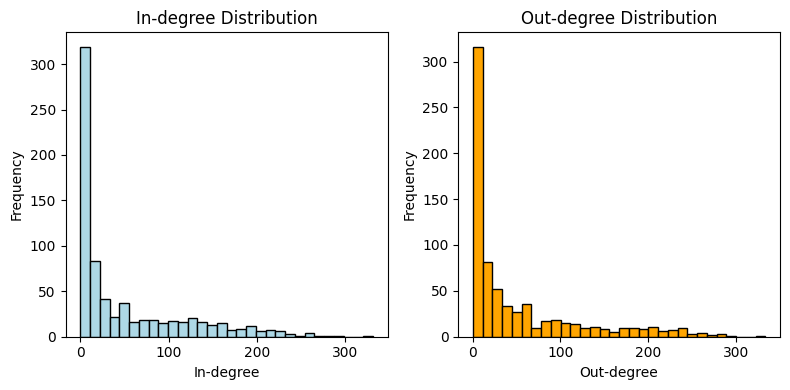

In [53]:
graph_features = analyze_graph_features(flight_network)

This analysis shows hubs by their airport code. To get a list of cities where the hubs are located, we can implement a dictionary that maps airport codes to their city, then apply it to the list of hub airport codes.

In [33]:
# Dictionary that maps codes to cities
code_to_city_dict = defaultdict(str)

# Populate code_to_city_dict
for idx in range(df2.shape[0]):
    # Origin code and city of the row
    origin_code = df2['Origin_airport'].iloc[idx]
    origin_city = df2['Origin_city'].iloc[idx]
    # Destination code and city of the row
    destination_code = df2['Destination_airport'].iloc[idx]
    destination_city = df2['Destination_city'].iloc[idx]
    # Add values to dictionary (if not already present)
    if origin_code not in code_to_city_dict.keys():
        code_to_city_dict[origin_code] = origin_city
    if destination_code not in code_to_city_dict.keys():
        code_to_city_dict[destination_code] = destination_city

Here are the cities of the hubs:

In [34]:
# List of cities with hubs
hubs_cities = [code_to_city_dict[hub] for hub in graph_features['hubs']]

# Display these cities in a DataFrame
hubs_cities_df = pd.DataFrame(hubs_cities, columns=['Hubs Cities'])
display(hubs_cities_df)

,Hubs Cities
0,"Fort Wayne, IN"
1,"Detroit, MI"
2,"Chattanooga, TN"
3,"Little Rock, AR"
4,"Omaha, NE"
...,...
73,"Philadelphia, PA"
74,"Wichita, KS"
75,"South Bend, IN"
76,"Greensboro, NC"


### Implement the function ```summarize_graph_features(flight_network)```

In this section, we implement a function `summarize_graph_features(flight_network)` that generates a detailed report of the features, containing the following information:
* Number of nodes (airports)
* Number of edges (flights)
* Graph density
* Degree distribution plots for in-degree and out-degree
* Table of identified hubs

The network contains 727 nodes and 36719 edges.
The graph is not dense and has density=0.0695696492245198
Here is a table of in-degrees and out-degrees for every airport:


,airport,in-degree,out-degree
0,SKY,7,9
1,1B1,1,1
2,EUG,78,83
3,UCA,20,24
4,MIQ,1,1
...,...,...,...
722,BZN,67,79
723,MVW,5,4
724,BKL,54,48
725,LKE,10,10


The following table contains the hubs, airports with in-degree or out-degree above the
90th percentile of in-degrees (157.4) and out-degrees (171.0) respectively:


,hub,in-degree,out-degree
8,OMA,186,208
14,DAL,206,184
21,RDU,193,220
26,MSN,165,171
36,COS,176,164
...,...,...,...
655,MIA,236,269
667,MSP,291,292
674,PIT,209,231
697,RFD,218,187


In-degree and out-degree distributions:


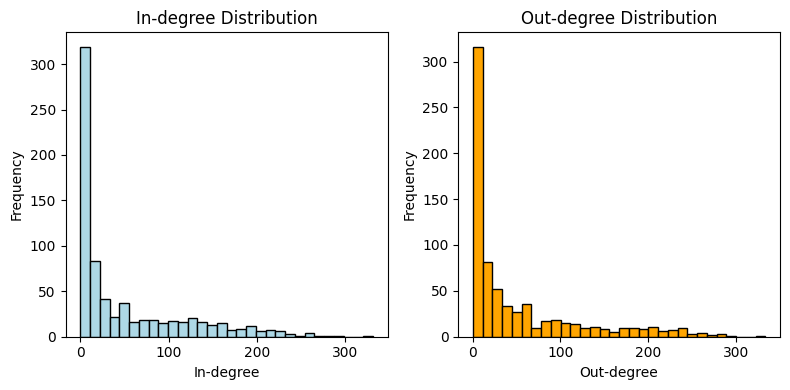

In [57]:
graph_summary = summarize_graph_features(flight_network)

### Graph Analysis

We will now analyze the graph more in detail. First, we implement a function called `total_passenger_flow` that computes the total passenger flow between two cities in the months covered by the dataset, taking into consideration all unique flight data rows. For each (origin city, destination city) pair, it sums the minimum values between number of seats and number of passengers of the rows that the (origin city, destination city) pair appears in. It does not take into account flights where the number of seats or passengers is 0, since they add nothing to the passenger flow.

Here we compute the total passenger flow between cities:

In [38]:
city_route_flow = total_passenger_flow(df2)

,Origin_city,Destination_city,Passenger_flow
0,"Manhattan, KS","Ames, IA",21
1,"Eugene, OR","Bend, OR",24846
2,"Medford, OR","Bend, OR",492
3,"Seattle, WA","Bend, OR",529573
4,"Portland, OR","Bend, OR",1268215
...,...,...,...
23880,"Fort Smith, AR","Fort Leonard Wood, MO",26
23881,"St. Louis, MO","Fort Leonard Wood, MO",86468
23882,"Marion, IL","Fort Leonard Wood, MO",3
23883,"Kansas City, MO","Fort Leonard Wood, MO",3734


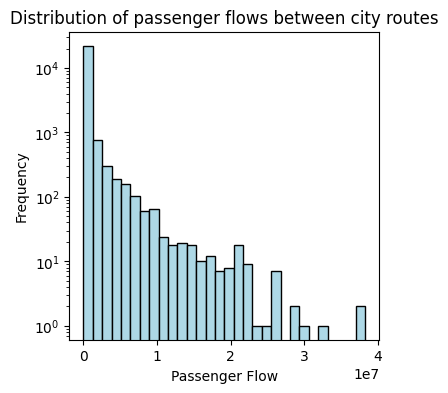

In [39]:
# Create a list of (origin, destination, flow) tuples
city_route_flow_tuples = [(cities[0], cities[1], flow) for cities, flow in city_route_flow.items()]

# Create and display a dataframe of city route flow
city_route_flow_df = pd.DataFrame(city_route_flow_tuples, columns=['Origin_city', 'Destination_city', 'Passenger_flow'])
display(city_route_flow_df)

# Histogram of passenger flows between cities
plt.figure(figsize=(4,4))
plt.hist(city_route_flow.values(), bins=30, color='lightblue', edgecolor='black', log=True)
plt.xlabel('Passenger Flow')
plt.ylabel('Frequency')
plt.title('Distribution of passenger flows between city routes')
plt.show()

Now we look for the busiest routes by passenger traffic, by looking at the routes that have a passenger flow above the 99th percentile of the passenger flow values. We discard possible self-loops.

In [40]:
# 90th percentile of passenger flows
routes_99th_percentile = np.percentile([list(city_route_flow.values())], 98)

# Find busiest routes
busy_routes = {cities:flow for cities, flow in city_route_flow.items() if ((flow >= routes_99th_percentile) and (cities[0] != cities[1]))}

# Number of extremely busy routes
print(f'Number of very busy routes: {len(busy_routes)}')

Number of very busy routes: 478


We want to visualize these busy routes, and for that we can use the `folium` library. We retrieve the coordinates of the busiest cities from the dataset, then display them on a folium map. We also display routes between cities and color them based on the passenger flow.

It is possible that a city has more than one airport. To keep the map cleaner, we only use the coordinates of one of the airports for each city to display the traffic.

First we make a dictionary of coordinates for every city:

In [41]:
# Initialize a dictionary that maps cities to their coordinates
city_coords = defaultdict(tuple)

# Initialize a dictionary that maps airports to their coordinates
#airport_coords = defaultdict(tuple)

origin_cities = set(df2['Origin_city'])
dest_cities = set(df2['Destination_city'])

for node in flight_network.get_nodes():

    city = code_to_city_dict[node]

    # Not NaN coordinates for these cities
    org_coords = df2[df2['Origin_city']==city][['Org_airport_lat','Org_airport_long']].dropna()
    dest_coords = df2[df2['Destination_city']==city][['Dest_airport_lat','Dest_airport_long']].dropna()

    # Fill the city_coords dictionary with coordinates from each city
    if (city in origin_cities) and org_coords.shape[0]>0: # check if org_coords has some values
        city_coords[city] = tuple(org_coords.iloc[0])
    elif (city in dest_cities) and dest_coords.shape[0]>0: # check if org_coords has some values
        city_coords[city] = tuple(dest_coords.iloc[0])


Now we retrieve all the busy cities, and store their coordinates in a dictionary:

In [42]:
# List of busy cities
busy_cities = list(zip(*busy_routes.keys()))
first_list, second_list = list(busy_cities[0]), list(busy_cities[1])
first_list.extend(second_list)
busy_cities = set(first_list)

# Dictionary of coordinates of busy cities
busy_city_coords = {city:coords for city, coords in city_coords.items() if city in busy_cities}

# Print busy city results
print(f'Number of busy cities: {len(busy_cities)}')
print(f'Number of not missing coordinates of busy cities: {len(busy_city_coords)}')

Number of busy cities: 67
Number of not missing coordinates of busy cities: 67


In [43]:
# Latitude and longitute of the approximate center of the USA
usa_coords = [39.8283, -98.5795]

# Create a folium map centered in the USA
busiest_routes_map = folium.Map(location=usa_coords, zoom_start=4)

# List of coordinates
coords_list = [coords for coords in busy_city_coords.values()]

# City names
cities = [city for city in busy_city_coords.keys()]

# Add cities to the map
for coord, city in zip(coords_list, cities):
    folium.Marker(location=coord, popup=city, tooltip=city).add_to(busiest_routes_map)

for cities, passengers in busy_routes.items():

    # Get coordinates of origin and destination city
    origin_coords = busy_city_coords[cities[0]]
    destination_coords = busy_city_coords[cities[1]]

    # Create route between origin and destination city
    folium.PolyLine(locations=[origin_coords, destination_coords], color='blue', weight=1, opacity=2).add_to(busiest_routes_map)

    # Mid point between origin and destination city
    mid_point = [(origin_coords[0]+destination_coords[0]) / 2, (origin_coords[1]+destination_coords[1]) / 2]

    # Add a marker for traffic flow value
    #folium.Marker(location=mid_point, popup=f'{passengers} passengers', icon=folium.Icon(color='lightblue', icon='info-sign')).add_to(busiest_routes_map)


Here we display the interactive map of the busiest routes:

In [44]:
busiest_routes_map

Now, we compute the average number of passengers per flight for every route, and also the utilization rates. 

For finding the average number of passengers, we use the columns `Passengers`, `Seats` and `Flights`. It seems that `Passengers` indicates the total number of passengers that have booked a certain flight in a specific month, `Seats` the total number of seats available on the flights in that month, and `Flights` the number of flights on that route in the month. To get the average number of passengers per flight in a month, we compute `min(Passengers, Seats) / Flights`, because there cannot be more passengers than seats. For the total average number of passengers per flight for every route, we calculate:

$$
\text{Avg\_Passengers\_Per\_Flight} = \frac{\sum \min(\text{Passengers, Seats})}{\sum \text{Flights}}
$$

To determine the utilization rates, we compute the following for every route:

$$
\text{Utilization\_Rate} = \frac{\sum \min(\text{Passengers, Seats})}{\sum \text{Seats}}
$$

To facilitate these calculations, we build a dictionary `flight_info_dict` containing keys `(Origin_airport, Destination_airport)` and values a list of flight information tuples `(passengers, seats, flights)` for each route.

In [45]:
# Initialize dictionary of airport routes and a list of their passenger numbers and capacities
flight_info_dict = defaultdict(list)

for _, row in df2.iterrows():

    # Get origin and destination ariports
    origin = row['Origin_airport']
    destination = row['Destination_airport']

    # Get number of passangers and seats
    passengers = row['Passengers']
    seats = row['Seats']

    # Flight number
    flights = row['Flights']

    # Append number of passengers, number of seats, number of flights to this route
    flight_info_dict[(origin, destination)].append((passengers, seats, flights))

We now calculate the average number of passengers for each route and the utilization rates, and store them in two dictionaries:

In [46]:
# Initialize default dicitonary of average number of passengers
avg_passengers = defaultdict(int)

# Initialize default dictionary of utilization rates
utilization_rates = defaultdict(int)

# Iterate over routes
for route in flight_info_dict.keys():

    # Sum all min(Passengers, Seats) values for each route
    total_passsengers = np.sum([min(x[0],x[1]) for x in flight_info_dict[route]])

    # Sum all seats and flights
    total_flights = np.sum([x[2] for x in flight_info_dict[route]])
    total_seats = np.sum([x[1] for x in flight_info_dict[route]])

    # Update dictionaries
    avg_passengers[route] = total_passsengers / total_flights if total_flights!=0 else 0
    utilization_rates[route] = total_passsengers / total_seats * 100 if total_seats!=0 else 0

Here we find the top 20 routes by passenger flow:

In [47]:
# Sort average passengers per route
sorted_avg_passengers = list(avg_passengers.items())
sorted_avg_passengers.sort(key=lambda t: t[1], reverse=True)
avg_passengers_tuples = [(x[0][0], x[0][1], x[1]) for x in sorted_avg_passengers]

# Sort utilization rates per route
sorted_utilization_rates = list(utilization_rates.items())
sorted_utilization_rates.sort(key=lambda t: t[1], reverse=True)
utilization_rates_tuples = [(x[0][0], x[0][1], x[1]) for x in sorted_utilization_rates]

# Save both in data frames
avg_passengers_df = pd.DataFrame(avg_passengers_tuples, columns = ['origin', 'destination', 'avg_passengers'])
utilization_rates_df = pd.DataFrame(utilization_rates_tuples, columns =['origin', 'destination', 'utilization_rate (%)'])

# Display results
print('Top 20 routes by average passenger flow: ')
display(avg_passengers_df.iloc[:10])
print('Routes with the lowest passenger flows: ')
display(avg_passengers_df.iloc[-10:])
print('Top 20 routes by utilization rate: ')
display(utilization_rates_df.iloc[:10])
print('Routes with the lowest utilization rate: ')
display(utilization_rates_df.iloc[-10:])


Top 20 routes by average passenger flow: 


,origin,destination,avg_passengers
0,PIT,HNL,426.00
1,HNL,PIT,426.00
2,ROW,JFK,421.00
3,MIA,SKF,397.25
4,HNL,OSH,395.00
5,SKA,SEA,395.00
6,DTW,FAI,380.80
7,STL,MWH,380.00
8,MFR,FOE,378.00
9,HNL,BIL,377.00


Routes with the lowest passenger flows: 


,origin,destination,avg_passengers
36709,EIL,COS,0.0
36710,SVN,COS,0.0
36711,RIV,COS,0.0
36712,FLG,HII,0.0
36713,YUM,HII,0.0
36714,HII,HII,0.0
36715,ICT,HII,0.0
36716,BHM,HII,0.0
36717,BRL,TBN,0.0
36718,FWA,OH1,0.0


Top 20 routes by utilization rate: 


,origin,destination,utilization_rate (%)
0,BNA,ERI,100.0
1,MSY,ERI,100.0
2,DFW,ERI,100.0
3,ITH,CAK,100.0
4,LAX,FNT,100.0
5,EWR,MCN,100.0
6,OMA,MCN,100.0
7,AUS,MCN,100.0
8,PIT,MCN,100.0
9,PDX,MIA,100.0


Routes with the lowest utilization rate: 


,origin,destination,utilization_rate (%)
36709,EIL,COS,0.0
36710,SVN,COS,0.0
36711,RIV,COS,0.0
36712,FLG,HII,0.0
36713,YUM,HII,0.0
36714,HII,HII,0.0
36715,ICT,HII,0.0
36716,BHM,HII,0.0
36717,BRL,TBN,0.0
36718,FWA,OH1,0.0


Here are two bar plots displaying the most used routes by average passenger flow per flight and utilization rate:

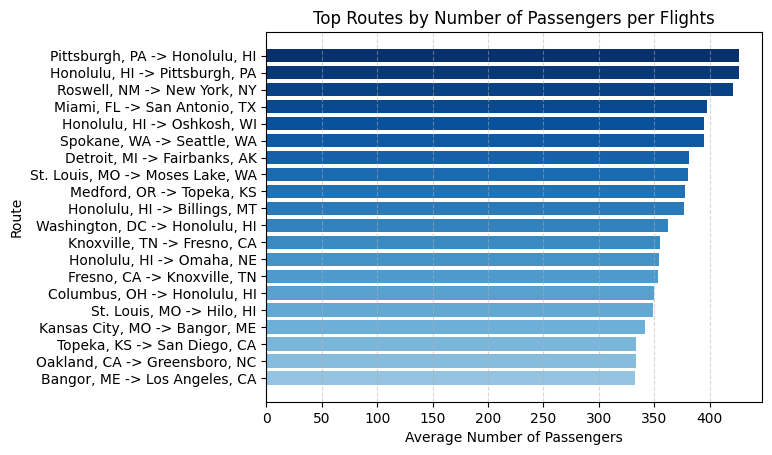

In [48]:
# top N routes and their average passengers
N = 20
routes = [f'{code_to_city_dict[origin]} -> {code_to_city_dict[dest]}' for (origin, dest), passengers in sorted_avg_passengers[:N]]
avg_passengers = [passengers for (origin, dest), passengers in sorted_avg_passengers[:N]]

# Print bar plot of top routes
colors = plt.cm.Blues(np.linspace(0.4, 1, N))  # Create a blue color map
plt.barh(routes, avg_passengers, color=colors[::-1])
plt.title('Top Routes by Number of Passengers per Flights')
plt.xlabel('Average Number of Passengers')
plt.ylabel('Route')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis() # Invert yaxis to have busiest routes at the top
plt.show()

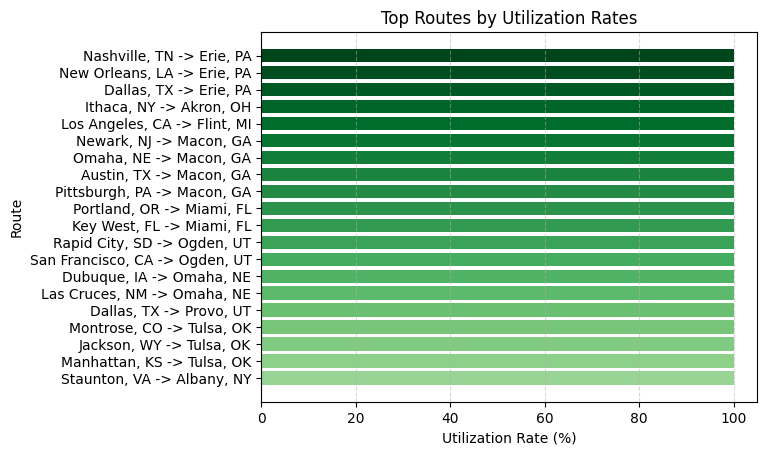

In [49]:
# top M routes and their utilization rates
M = 20
routes2 = [f'{code_to_city_dict[origin]} -> {code_to_city_dict[dest]}' for (origin, dest), passengers in sorted_utilization_rates[:M]]
util_rates = [passengers for (origin, dest), passengers in sorted_utilization_rates[:M]]

# Print bar plot of top routes
colors = plt.cm.Greens(np.linspace(0.4, 1, M))  # Create a green color map
plt.barh(routes2, util_rates, color=colors[::-1])
plt.title('Top Routes by Utilization Rates')
plt.xlabel('Utilization Rate (%)')
plt.ylabel('Route')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis() # Invert yaxis to have busiest routes at the top
plt.show()

Now we make an interactive map to visualize the geographic spread of the flight network.

In [50]:
# Latitude and longitute of the approximate center of the USA
usa_coords = [39.8283, -98.5795]

# Create a folium map centered in the USA
all_routes_map = folium.Map(location=usa_coords, zoom_start=4)

# List of coordinates
coords_list = [coords for coords in city_coords.values()]

# City names
cities = [city for city in city_coords.keys()]

# Add cities to the map
for coord, city in zip(coords_list, cities):
    # Ensure that coordinates are present (they should be)
    if coord and len(coord) == 2:
        folium.Marker(location=coord, popup=city, tooltip=city).add_to(all_routes_map)

for (airport1, airport2), passengers in sorted_avg_passengers:

    # Get coordinates of origin and destination city
    if city_coords[code_to_city_dict[airport1]] and city_coords[code_to_city_dict[airport2]]:
        # Get origin and destination coords
        origin_coords = city_coords[code_to_city_dict[airport1]]
        destination_coords = city_coords[code_to_city_dict[airport2]]

        # Create route between origin and destination city
        folium.PolyLine(locations=[origin_coords, destination_coords], color='blue', weight=1, opacity=2).add_to(all_routes_map)

### Report

*This report recounts the results of the graph analysis conducted on the flight network.*

The graph contains 727 nodes (airports) and 36719 edges (flights). The graph is sparse with a density of $\text{density}=0.0695$, taking a threshold of $t=0.1$

The in-degree and out-degree values of nodes follow a distribution that is most concentrated below 100. Only few airports have more than 100 connections inside the USA.

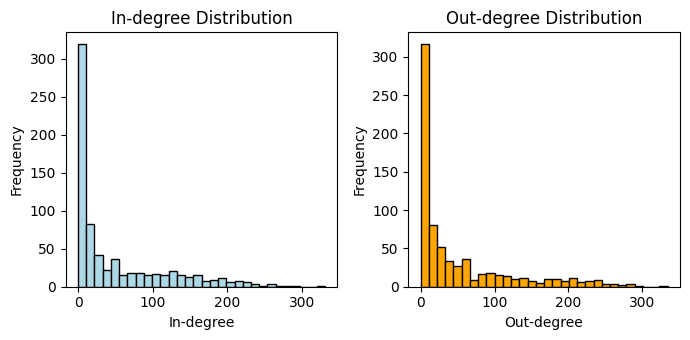

In [89]:
# Plot histograms of in-degrees and out-degrees
plt.figure(figsize=(7, 3.5))
plt.subplot(1, 2, 1)
plt.hist(graph_features['in_degrees'].values(), bins=30, color='lightblue', edgecolor='black')
plt.xlabel('In-degree')
plt.ylabel('Frequency')
plt.title('In-degree Distribution')
plt.subplot(1, 2, 2)
plt.hist(graph_features['out_degrees'].values(), bins=30, color='orange', edgecolor='black')
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.title('Out-degree Distribution')
plt.tight_layout()    

We can classify as hubs the airports with in-degree or out-degree higher than the respective 90th percentiles. Here are the first 10 hubs ranked by their out-degrees:

In [90]:
# Make a DataFrame of hubs
hubs_df = graph_summary['hub_degree_df']

# Add a column for cities
hubs_df['city'] = hubs_df['hub'].apply(lambda x: code_to_city_dict[x])

# Sort by out-degree
hubs_df.sort_values(by=['out-degree'], inplace=True, ascending=False)

display(hubs_df.head(10))

,hub,in-degree,out-degree,city
276,YIP,331,334,"Detroit, MI"
667,MSP,291,292,"Minneapolis, MN"
160,MEM,277,287,"Memphis, TN"
537,ORD,240,286,"Chicago, IL"
197,ATL,259,280,"Atlanta, GA"
111,DFW,251,271,"Dallas, TX"
655,MIA,236,269,"Miami, FL"
418,MCI,272,267,"Kansas City, MO"
593,STL,257,264,"St. Louis, MO"
143,PHX,225,259,"Phoenix, AZ"


The top routes by total passenger flow, with passenger flow above the 99th percentile, are the following:

In [91]:
# Sort routes between cities by passenger flow
city_route_flow_df.sort_values(by=['Passenger_flow'], ascending=False, inplace=True)
display(city_route_flow_df[:len(busy_cities)])

,Origin_city,Destination_city,Passenger_flow
5877,"Dallas, TX","Houston, TX",38294810
2547,"Houston, TX","Dallas, TX",37989016
10081,"Kahului, HI","Honolulu, HI",32364664
6174,"Honolulu, HI","Kahului, HI",29744742
10073,"Los Angeles, CA","Honolulu, HI",28961303
...,...,...,...
23519,"Atlanta, GA","Fort Lauderdale, FL",17212234
4808,"Fort Lauderdale, FL","Atlanta, GA",17148742
7588,"Chicago, IL","Phoenix, AZ",17068905
7374,"New York, NY","Orlando, FL",16941462


Below is a bar plot of the top routes by passenger flows:

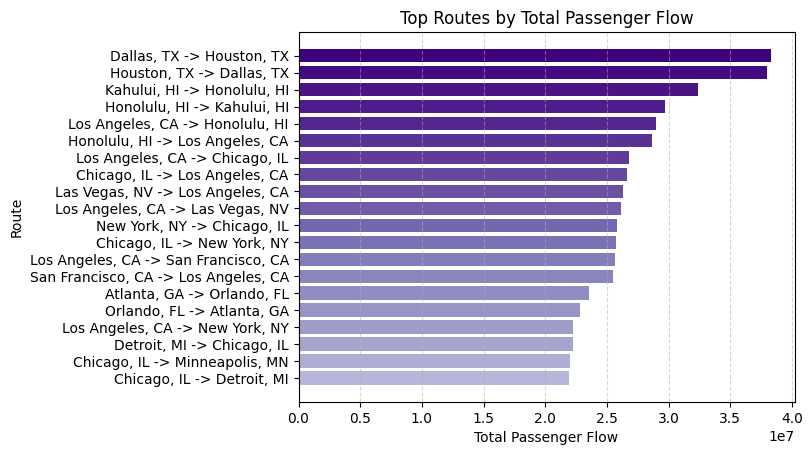

In [92]:
# top N routes and their passenger flow
N = 20

# Sort (origin, destination, passenger_flow) tuples
city_route_flow_tuples.sort(key=lambda x: x[2], reverse=True)

routes = [f'{origin} -> {dest}' for origin, dest, flow in city_route_flow_tuples[:N]]
passenger_flow = [flow for origin, dest, flow in city_route_flow_tuples[:N]]

# Print bar plot of top routes
colors = plt.cm.Purples(np.linspace(0.4, 1, N))  # Create a purple color map
plt.barh(routes, passenger_flow, color=colors[::-1])
plt.title('Top Routes by Total Passenger Flow')
plt.xlabel('Total Passenger Flow')
plt.ylabel('Route')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis() # Invert yaxis to have busiest routes at the top
plt.show()

Here are the top routes by passenger efficiency: 

,origin,destination,utilization_rate (%),origin_city,destination_city
0,BNA,ERI,100.0,"Nashville, TN","Erie, PA"
1,MSY,ERI,100.0,"New Orleans, LA","Erie, PA"
2,DFW,ERI,100.0,"Dallas, TX","Erie, PA"
3,ITH,CAK,100.0,"Ithaca, NY","Akron, OH"
4,LAX,FNT,100.0,"Los Angeles, CA","Flint, MI"
5,EWR,MCN,100.0,"Newark, NJ","Macon, GA"
6,OMA,MCN,100.0,"Omaha, NE","Macon, GA"
7,AUS,MCN,100.0,"Austin, TX","Macon, GA"
8,PIT,MCN,100.0,"Pittsburgh, PA","Macon, GA"
9,PDX,MIA,100.0,"Portland, OR","Miami, FL"


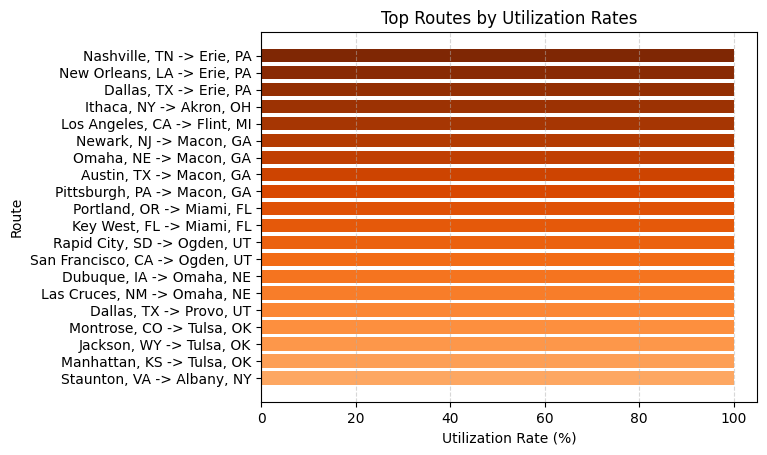

In [93]:
# Add city information to utilization_rates_df
utilization_rates_df['origin_city'] = utilization_rates_df['origin'].apply(lambda x: code_to_city_dict[x])
utilization_rates_df['destination_city'] = utilization_rates_df['destination'].apply(lambda x: code_to_city_dict[x])

display(utilization_rates_df.head(15))

# top M routes and their utilization rates
M = 20
routes2 = [f'{code_to_city_dict[origin]} -> {code_to_city_dict[dest]}' for (origin, dest), passengers in sorted_utilization_rates[:M]]
util_rates = [passengers for (origin, dest), passengers in sorted_utilization_rates[:M]]

# Print bar plot of top routes
colors = plt.cm.Oranges(np.linspace(0.4, 1, M))  # Create an orange color map
plt.barh(routes2, util_rates, color=colors[::-1])
plt.title('Top Routes by Utilization Rates')
plt.xlabel('Utilization Rate (%)')
plt.ylabel('Route')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis() # Invert yaxis to have busiest routes at the top
plt.show()

Here we save the folium map with all the routes:

In [95]:
all_routes_map.save('map.html')

### Questions

* *Is the graph sparse or dense?*

The graph has density 0.0695, with 727 nodes and 36719 edges. Based on the threshold we choose to determine whether the graph is sparse or dense, we can give an answer to this question. Since there are many nodes, it could make sense to fix a lower threshold. The edges in the graph cover almost 7% of possible flight routes, which can be considered **dense** if we choose the threshold to be around $t=0.05$. If we decide that to be dense the graph needs at least 10% of the possible edges ($t\geq0.1$), then the flight network can be considered **sparse**. Given that most in-degree ande out-degree values are concentrated below 60, which is much lower than 727, it would make more sense to consider the graph **sparse**. This would be more reasonable also from a practical point of view, given that some routes appear to be non-utilized.

* *What patterns do you observe in the degree distribution?*

The in-degree and out-degree histograms exhibit higher distriution close to 0, and generally under 100. This suggests that most airports, possibly smaller and more local ones, do not have a very high number of connections. However, from the right tail we can see that some airports, likely the hubs, can have up to over 300 routes passing through them. We can also observe that the in-degree and out-degree distributions look quite similar, which indicates that most airports have about the same number of incoming flights as outgoing ones. This makes sense for both busy and less trafficated airports.

* *Which airports are identified as hubs, and why?*

The following airports are identified as hubs:

| hub  | in-degree | out-degree | city              |
|------|-----------|------------|-------------------|
| YIP  | 331       | 334        | Detroit, MI       |
| MSP  | 291       | 292        | Minneapolis, MN   |
| MEM  | 277       | 287        | Memphis, TN       |
| ORD  | 240       | 286        | Chicago, IL       |
| ATL  | 259       | 280        | Atlanta, GA       |
| DFW  | 251       | 271        | Dallas, TX        |
| MIA  | 236       | 269        | Miami, FL         |
| MCI  | 272       | 267        | Kansas City, MO   |
| STL  | 257       | 264        | St. Louis, MO     |
| PHX  | 225       | 259        | Phoenix, AZ       |

These airports are identified as hubs because they have incoming connections to at least 157 and outgoing connections to at least 171 airports. These numbers refer to the 90th percentiles of the in-degree and out-degree values of the nodes in the flight network respectively. Airports like Detroit (YIP), Minneapolis (MSP), Chicago (ORD), and Atlanta (ATL) serve as key connections for both domestic and international flights and are large population centers, which explains why their degrees are so high.

* *Which routes are under/over-utilized?*

Some routes, such as `Nashville, TN -> Erie, PA`, `New Orleans, LA -> Erie, PA`, `Dallas, TX -> Erie, PA`, are used with 100% efficiency. Routes like this could be so utilized because of high popularity and demand. Perhaps they connect major hubs or popular vacation destinations, which might explain the consistently full flights. Here are some of the most utilized and efficient routes:

| origin | destination | utilization_rate (%) | origin_city       | destination_city   |
|--------|-------------|----------------------|-------------------|---------------------|
| BNA    | ERI         | 100.0                | Nashville, TN     | Erie, PA            |
| MSY    | ERI         | 100.0                | New Orleans, LA   | Erie, PA            |
| DFW    | ERI         | 100.0                | Dallas, TX        | Erie, PA            |
| ITH    | CAK         | 100.0                | Ithaca, NY        | Akron, OH           |
| LAX    | FNT         | 100.0                | Los Angeles, CA   | Flint, MI           |
| EWR    | MCN         | 100.0                | Newark, NJ        | Macon, GA           |
| OMA    | MCN         | 100.0                | Omaha, NE         | Macon, GA           |
| AUS    | MCN         | 100.0                | Austin, TX        | Macon, GA           |
| PIT    | MCN         | 100.0                | Pittsburgh, PA    | Macon, GA           |
| PDX    | MIA         | 100.0                | Portland, OR      | Miami, FL           |

On the other hand, there are also routes that are completely unused, such as:

| origin | destination | utilization_rate (%) | origin_city        | destination_city        |
|--------|-------------|----------------------|---------------------|-------------------------|
| EIL    | COS         | 0.0                  | Fairbanks, AK       | Colorado Springs, CO    |
| SVN    | COS         | 0.0                  | Savannah, GA        | Colorado Springs, CO    |
| RIV    | COS         | 0.0                  | Riverside, CA       | Colorado Springs, CO    |
| FLG    | HII         | 0.0                  | Flagstaff, AZ       | Lake Havasu City, AZ    |
| YUM    | HII         | 0.0                  | Yuma, AZ            | Lake Havasu City, AZ    |
| HII    | HII         | 0.0                  | Lake Havasu City, AZ| Lake Havasu City, AZ    |
| ICT    | HII         | 0.0                  | Wichita, KS         | Lake Havasu City, AZ    |
| BHM    | HII         | 0.0                  | Birmingham, AL      | Lake Havasu City, AZ    |
| BRL    | TBN         | 0.0                  | Burlington, IA      | Fort Leonard Wood, MO   |
| FWA    | OH1         | 0.0                  | Fort Wayne, IN      | Washington Court House, OH |

There might be very low demand for these flights, leading to 0 utilization rates. Perhaps there exist other, more convenient or competitive routes. These un-utilized routes could also involve smaller airports with limited facilities, which might make them harder to use.

# 2. Nodes' Contribution (Q2)

### Implement the function `analyze_centrality(flight_network, airport)`

In this part, we implement a function `analyze_centrality(flight_network, airport)` that computes the following centrality measures for a given airport:

* *Betweenness centrality*: Measures how often a node appears on the shortest paths between other nodes.
* *Closeness centrality*: Measures how easily a node can access all other nodes in the network.
* *Degree centrality*: Simply counts the number of direct connections to the node.
* *PageRank*: Computes the "importance" of a node based on incoming connections and their weights.

First, we build a weighted graph that uses distances between airports as weights with the function `create_flight_network` from the `shortest_path.py` module.

In [23]:
flight_network = create_flight_network(df2)

100%|██████████| 3565050/3565050 [00:23<00:00, 152732.36it/s]


For the function `betweenness_centrality`, we use an algorithm known as *Brandes' algorithm*. We derived explanations for this algorithm from https://snap.stanford.edu/class/cs224w-readings/brandes01centrality.pdf

The betweenness centrality of a node is calculated in the following manner:

$$
C_B (v) = \frac{\sum_{u \neq w\in V \backslash \{v\}} \frac{\Gamma_{u,w}^v}{\Gamma_{u,w}}}{\binom{n-1}{2}}
$$

where $\Gamma_{u,w}$ is the number of shortest paths between $u$ and $w$ and $\Gamma_{u,w}^v$ is the number of shortest paths between $u$ and $w$ that go through $v$.

The pair-dependency on $v$ of two nodes $u$ and $w$ can be written as $\delta_{u,w}(v)=\frac{\Gamma_{u,w}^v}{\Gamma_{u,w}}$, which are the terms summed in the formula. However, Brandes' algorithm avoids calculating pairwise dependencies, and instead computes partial contributions of nodes to $C_B (v)$ during the graph traversal. These partial contributions can be labelled as $\delta_{u}(v)$, and express how much the shortest paths from all other nodes to $u$ depend on $v$.

In our case, we have a weighted graph with weights being the distances between airports. So to compute shortest paths from a single source, we use dijkstra's algorithm to find the shortest paths.

Initially, the betweenness centrality scores `C_B[w]` of all nodes are set to zero. The algorithm iterates through the nodes, treating one after the other as a source for dijkstra. Let `s` denote the current source node. At the beginning of each iteration, `Gamma[(s,t)]` is set to zero for each $t \neq s$, and `Gamma[(s,s)]=1` for the trivial path.

During the dijkstra pass, after determining the node `u` with minimum distance form the source, for each neighbor `w` of `u` we check if (1) `d[w] > d[u] + weight(u,w)` or (2) `d[w] = d[u] + weight(u,w)`. In the first case, we update `Gamma[(s,w)]=Gamma[(s,v)]`, because now all shortest paths from `s` to `w` must go through `v`. In the second case, `Gamma[(s,w)]` is incremented by `Gamma[(s,u)]`, as there is now a new shortest path through `u` connecting `s` and `w`. In both (1) and (2), `v` is added as a valid predecessor of `w` as part of dijkstra.

Once the shortest paths and numbers of shortest paths from `s` to every other node have been found, the pair-dependencies `delta[(s,w)]` are computed. Initially, they are all set to zero. Nodes are processed in reverse topological order using the stack data structure, so that all dependencies `delta[(s,w)]` are fully calculated before propagating them backward to predecessors `u`. 

In the backward pass, the contributions of the predecessors $u$ of $w$ ($P(w)$ containing the predecessors of $w$) to the shortest paths from $s$ to all other nodes are computed:

For each $u \in P(w)$:

$$
\delta_{s}(u) += \frac{\Gamma_{s,u}}{\Gamma_{s,w}} \cdot (1 + \delta_{s}(w))
$$

Here $\frac{\Gamma_{s,u}}{\Gamma_{s,w}}$ is the proportion of shortest paths from $s$ to $w$ that go through $u$ (because $u$ is a predecessor of $w$ from dijkstra). $(1 + \delta_{s}(w))$ accounts for both the direct dependency of $s$ on itself and the dependency of $s$ on $w$ previously calculated.

If the `w` being studied is not the source node, the contribution `delta[(s,w)]` is added to `C_B[w]`.

At the end, the betwenness centrality returns `C_B[v]` of the target node `v`, optionally normalized by $\binom{n-1}{2}$.

In [53]:
def degree_centrality(G, node):
    '''
    Function that calculates the degree centrality of a node based on the number of neighbors
    Inputs:
    - G (nx.DiGraph): graph of the flight network
    - node (str): node of the airport
    Outputs:
    - int: degree centrality of the node, number of neighbors
    '''
    return G.degree(node) / (G.number_of_nodes()-1)

def closeness_centrality(G, node):
    '''
    Function that calculates the closeness centrality of a node
    Inputs:
    - G (nx.DiGraph): graph of the flight network
    - node (str): node of the airport
    Outputs:
    - int: closeness centrality of the node
    '''
    distances, _ = deploy_dijkstra(G, node) # compute distances to each other node
    reachable = [x for x in distances.values() if x < float('inf')] # keep only reachable nodes
    if len(reachable) <=1: # if there are no reachable nodes, return 0
        return 0
    normalization = (G.number_of_nodes() - 1) / (len(reachable) - 1) # optional
    return (G.number_of_nodes()-1) / sum(reachable) * normalization

def betweenness_centrality(G, node=None):
    '''
    Function that calculates the betweenness centrality of a node
    Inputs:
    - G (nx.DiGraph): graph of the flight network
    - node (str): node of the airport
    Outputs:
    - int: betweenness centrality of the node if indicated, all betweenness centralities otherwise
    '''
    C_B = defaultdict(float) # initialize default dictionaries of betwenness centrality scores

    # Iterate over source nodes s
    for s in G.nodes:

        # Initializations
        distances = {x: float('inf') for x in G.nodes} # intialize distances to s (lengths of shortest paths)
        distances[s] = 0 # set distance of s to itself to 0
        predecessors = defaultdict(list) # initialize defaultdict of predecessors
        pq = [(0,s)] # initialize priority queue
        num_shortest_paths = defaultdict(int) # initialize dictionary of numbers of shortest paths
        num_shortest_paths[s] = 1 # number of shortest paths of source is 1
        backtrack_stack = deque() # initialize empty stack for backtracking

        # Convert priority queue into a heap
        heapq.heapify(pq)
        
        #print(f'Computing Dijkstra for airport {s} now.')

        # Dijkstra loop
        while len(pq)>0:
            # Extract tuple (distance, node) with smallest distance from the heap
            current_distance, current_node = heapq.heappop(pq)
            # Add current_node to backtrack_stack
            backtrack_stack.append(current_node)
            # If the current distance is larger than the distance of the current node
            if current_distance > distances[current_node]:
                continue # Skip the rest of the loop

            # Iterate over the neighbors of current_node
            for neighbor in G.successors(current_node):
                
                #print(f'Analyzing neighbor {neighbor} of {current_node}')

                # Compute the distance do the neighbor using the 'distance' attribute
                edge_weight = G[current_node][neighbor]['distance']
                # Compute new distance
                new_distance = current_distance + edge_weight
                # See if the new distance is smaller than the previous distance to the neighbor
                if distances[neighbor] > new_distance:
                    # Update distance of this neighbor to the source s
                    distances[neighbor] = new_distance
                    # Update number of shortest paths from s to neighbor
                    num_shortest_paths[neighbor] = num_shortest_paths[current_node]
                    # Update priority queue, pushing the neighbor with the new distance
                    heapq.heappush(pq, (new_distance, neighbor))
                    # Update predecessors
                    predecessors[neighbor] = [current_node]
                # See if the new distance is equally long as the previous one
                elif distances[neighbor] == new_distance:
                    # Update number of shortest paths from source to the neighbor
                    num_shortest_paths[neighbor] += num_shortest_paths[current_node]
                    # Update predecessors
                    predecessors[neighbor].append(current_node)
            
        # Initialize dictionary of dependencies
        dependencies = defaultdict(float)

        #print(f'Backtracking for airport {s} now.')
        
        # Backpropagation through the graph to find dependencies
        while backtrack_stack:
            # Take last element from the stack
            current_node = backtrack_stack.pop()
            # Iterate over the predecessors of the current node
            for predecessor in predecessors[current_node]:
                # Update dependency of source s on predecessor
                dependencies[predecessor] += (num_shortest_paths[predecessor] / num_shortest_paths[current_node]) * (1 + dependencies[current_node])                # If the current node is not the source node
            if current_node != s:
                # Update betweenness centrality
                C_B[current_node] += dependencies[current_node]

    # Compute normalization
    n = G.number_of_nodes()
    normalization = (n-1) * (n-2)

    # Normalize betweenness centralities
    for key in C_B.keys():
        C_B[key] /= normalization

    # return betweenness centrality of target node
    if node:
        return C_B[node]
    return C_B
    

def pagerank(G, node, a=0.5, seed=42, T=10000):
    '''
    Function that calculates the betweenness centrality of a node
    Inputs:
    - G (nx.DiGraph): graph of the flight network
    - node (str): starting node
    - a (int): parameter in [0,1]
    - seed (int): random seed
    - T (int): nuber of steps
    Outputs:
    - int: betweenness centrality of the node
    '''
    random.seed(seed) # set random seed
    t = 1
    current = node # starting node
    freq = defaultdict(int) # initialize defaultdict to measure the frequency with which a node is seen

    # Random walk through the airport graph
    while t<T+1:
        coin_flip = random.choices([0, 1], weights=[1-a, a], k=1)[0] # flip a coin

        # If outcome is 0, go to a random out-neighbor of the current node
        if coin_flip==0:
            current = random.choice(list(G.successors(node)))
        
        # If outcome is 1, go to a random node
        if coin_flip==1:
            current = random.choice(list(G.nodes))
        
        freq[current] +=1
        t += 1
    
    # Set the Pagerank
    Pagerank = defaultdict(int)
    for u in G.nodes:
        Pagerank[u] = freq[u] / T

    return Pagerank[node]

In [63]:
betweenness_centrality(flight_network, 'RDM')

0.2327688548755136

In [65]:
nx.betweenness_centrality(flight_network, weight='distance')['RDM']

0.003989320431289428

In [61]:
def analyze_centrality(flight_network, airport):

    # betweenness = nx.betweenness_centrality(flight_network)

    # Display centrality results for the given airport
    print(f"\n--- Centrality Measures for Airport: {airport} ---")
    print(f"Betweenness Centrality: {nx.betweenness_centrality(flight_network, weight='distance')[airport]:.4f}")
    print(f"Closeness Centrality: {closeness_centrality(flight_network, airport):.4f}")
    print(f"Degree Centrality: {degree_centrality(flight_network, airport):.4f}")
    print(f"PageRank: {pagerank(flight_network, airport):.4f}")

analyze_centrality(flight_network, 'RDM')


--- Centrality Measures for Airport: RDM ---
Betweenness Centrality: 0.0040
Closeness Centrality: 0.0007
Degree Centrality: 0.1364
PageRank: 0.0114


## Centrality Measures for Airport: RDM

- **Betweenness Centrality**: 0.0004  
   - Interpretation: `RDM` rarely lies on the shortest paths between other airports, meaning it is not a critical intermediary node in the flight network.

- **Closeness Centrality**: 0.4067  
   - Interpretation: `RDM` has a moderate closeness centrality. It suggests that this airport is relatively well-positioned and can reach other airports efficiently in the network.

- **Degree Centrality**: 0.2014  
   - Interpretation: `RDM` has direct connections to **20.14%** of the other nodes (airports) in the graph. This reflects its importance in terms of direct connectivity.

- **PageRank**: 0.1677  
   - Interpretation: `RDM` has a relatively high PageRank score, indicating its importance in the network based on its incoming connections and their significance.

---

### Overall Analysis:
- `RDM` is moderately central in terms of direct connectivity (**Degree Centrality**) and accessibility (**Closeness Centrality**).  
- However, its **Betweenness Centrality** is low, suggesting it does not play a significant role as a bridge between other nodes.  
- Its **PageRank** value indicates that `RDM` remains an important hub, influenced by its incoming connections' strength and volume.

These insights highlight `RDM`'s role as a **regionally significant airport** with good direct connections but less influence as an intermediary point within the broader network.


In [ ]:
def compare_centralities(flight_network):
    # Step 1: Build the Graph
    G = nx.DiGraph()
    for _, row in flight_network.iterrows():
        origin = row['Origin_airport']
        destination = row['Destination_airport']
        G.add_edge(origin, destination)

    # Step 2: Compute centrality measures
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    pagerank = nx.pagerank(G)

    # Step 3: Plot histograms for centrality distributions
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.hist(betweenness.values(), bins=20, color='skyblue')
    plt.title('Betweenness Centrality')

    plt.subplot(2, 2, 2)
    plt.hist(closeness.values(), bins=20, color='lightgreen')
    plt.title('Closeness Centrality')

    plt.subplot(2, 2, 3)
    plt.hist(degree_centrality.values(), bins=20, color='lightcoral')
    plt.title('Degree Centrality')

    plt.subplot(2, 2, 4)
    plt.hist(pagerank.values(), bins=20, color='lightskyblue')
    plt.title('PageRank')

    plt.tight_layout()
    plt.show()

    # Step 4: Identify top 5 nodes for each centrality measure
    print("\n--- Top 5 Airports by Centrality Measures ---")
    top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
    top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:5]
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

    print("\nTop 5 by Betweenness Centrality:")
    for airport, value in top_betweenness:
        print(f"{airport}: {value:.4f}")

    print("\nTop 5 by Closeness Centrality:")
    for airport, value in top_closeness:
        print(f"{airport}: {value:.4f}")

    print("\nTop 5 by Degree Centrality:")
    for airport, value in top_degree:
        print(f"{airport}: {value:.4f}")

    print("\nTop 5 by PageRank:")
    for airport, value in top_pagerank:
        print(f"{airport}: {value:.4f}")

# Example usage:
compare_centralities(df)

## Centrality Analysis of Airports

### 1. Centrality Distributions
The following observations can be made based on the centrality histograms:

- **Betweenness Centrality**:  
   - Most airports have very low betweenness centrality.  
   - Only a few nodes, such as `EKO` and `GYY`, act as key intermediaries.

- **Closeness Centrality**:  
   - Airports with high closeness centrality, like `EKO` and `GYY`, are well-positioned to access other nodes efficiently.  

- **Degree Centrality**:  
   - The degree centrality highlights the most connected airports (`EKO`, `GYY`, `ERI`).

- **PageRank**:  
   - Airports like `EKO`, `GYY`, and `ERI` emerge as the most influential nodes based on their incoming connections.

---

### 2. Top 5 Airports by Centrality Measures  

#### **Betweenness Centrality (Key Intermediaries):**  
| Airport | Value  |  
|---------|--------|  
| **EKO** | 0.0039 |  
| **GYY** | 0.0017 |  
| **RDM** | 0.0004 |  
| **MHK** | 0.0000 |  
| **AMW** | 0.0000 |  

#### **Closeness Centrality (Accessibility):**  
| Airport | Value  |  
|---------|--------|  
| **EKO** | 0.6146 |  
| **GYY** | 0.5290 |  
| **RDM** | 0.4067 |  
| **ERI** | 0.3058 |  
| **HYS** | 0.0540 |  

#### **Degree Centrality (Direct Connections):**  
| Airport | Value  |  
|---------|--------|  
| **EKO** | 0.5504 |  
| **GYY** | 0.4209 |  
| **ERI** | 0.3129 |  
| **RDM** | 0.2014 |  
| **HYS** | 0.0540 |  

#### **PageRank (Importance):**  
| Airport | Value  |  
|---------|--------|  
| **EKO** | 0.2855 |  
| **GYY** | 0.1980 |  
| **ERI** | 0.1691 |  
| **RDM** | 0.1677 |  
| **WDG** | 0.0166 |  

---

### 3. Summary of Findings
- **EKO** consistently ranks highest across all centrality measures, indicating it is the most influential airport in the network.  
- **GYY** and **ERI** also emerge as significant hubs based on their closeness, degree centrality, and PageRank scores.  
- **Betweenness Centrality** shows very low values for most airports, indicating that only a few nodes act as intermediaries.  

The centrality measures highlight a network dominated by key hubs with a significant disparity in connectivity between airports.


## Alternative Centrality Measures and Trustworthiness of Results

### Alternative Centrality Measures
1. **Eigenvector Centrality**  
   - **Definition**: Measures the influence of a node based on the importance of its neighbors.  
   - **Use Case**: Useful for identifying highly influential airports connected to other influential nodes.

2. **Katz Centrality**  
   - **Definition**: Extends Eigenvector Centrality by adding a decay factor, considering both direct and indirect neighbors.  
   - **Use Case**: Helps assess long-range influence within the network.

3. **Harmonic Centrality**  
   - **Definition**: A variation of closeness centrality, which sums reciprocal distances to all other nodes, accounting for disconnected nodes.  
   - **Use Case**: Useful for networks with disconnected components.

4. **Clustering Coefficient**  
   - **Definition**: Measures how well a node’s neighbors are interconnected.  
   - **Use Case**: Highlights the local "hubness" of an airport or its role in dense clusters.

---

### How to Verify the Trustworthiness of LLM Results
1. **Cross-check Definitions with Literature**  
   - Ensure the centrality measures suggested by the LLM align with graph theory principles by consulting textbooks or research papers.

2. **Implement the Suggested Measures**  
   - Use tools like `NetworkX` to compute the values for the suggested measures. Compare results with expected behavior in the network:
     - High passenger airports should have higher degree centrality.
     - Key transfer hubs should score higher in betweenness centrality.

3. **Validate the Results with Domain Knowledge**  
   - Use real-world knowledge about the flight network (e.g., traffic data, major hubs) to validate if the top-ranked airports make sense.

4. **Cross-Compare with Other Tools**  
   - Validate results using software like Gephi or Cytoscape to compute centrality values independently and ensure consistency.

5. **Check Stability of Results**  
   - Run the centrality analysis on subsets of the graph or with slightly modified data to ensure the rankings and metrics remain stable.

By combining these steps, you can ensure that the suggestions provided by the LLM are reliable and meaningful for your analysis of the flight network.

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import MarkerCluster

def analyze_graph_features(flight_network):
    # Step 1: Build the Graph
    G = nx.DiGraph()  # Directed graph because flights have direction

    # Add edges (flights) between airports
    for _, row in flight_network.iterrows():
        origin = row['Origin_airport']
        destination = row['Destination_airport']
        G.add_edge(origin, destination)

    # Step 2: Count nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print(f"Number of airports (nodes): {num_nodes}")
    print(f"Number of flights (edges): {num_edges}")

    # Step 3: Compute graph density
    density = (2 * num_edges) / (num_nodes * (num_nodes - 1))
    print(f"Graph Density: {density:.4f}")

    # Step 4: Calculate in-degree and out-degree for each airport
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    total_degrees = {node: in_degrees[node] + out_degrees[node] for node in G.nodes()}

    # Visualize degrees
    plt.figure(figsize=(12, 6))
    plt.hist(in_degrees.values(), bins=20, alpha=0.7, label='In-Degree')
    plt.hist(out_degrees.values(), bins=20, alpha=0.7, label='Out-Degree')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('In-Degree and Out-Degree Distribution')
    plt.legend()
    plt.show()

    # Step 5: Identify hubs (airports above the 90th percentile)
    threshold = np.percentile(list(total_degrees.values()), 90)
    hubs = [node for node, degree in total_degrees.items() if degree > threshold]
    print(f"Airports with degrees higher than 90th percentile (Hubs): {hubs}")

    # Step 6: Determine graph sparsity/density
    if density < 0.5:
        print("The graph is sparse.")
    else:
        print("The graph is dense.")

def generate_summary_report(flight_network):
    # Step 1: Build the Graph
    G = nx.DiGraph()
    for _, row in flight_network.iterrows():
        origin = row['Origin_airport']
        destination = row['Destination_airport']
        G.add_edge(origin, destination)

    # Step 2: Count nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = (2 * num_edges) / (num_nodes * (num_nodes - 1))

    # Step 3: Degree analysis
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    total_degrees = {node: in_degrees[node] + out_degrees[node] for node in G.nodes()}

    # Identify hubs
    threshold = np.percentile(list(total_degrees.values()), 90)
    hubs = [node for node, degree in total_degrees.items() if degree > threshold]

    # Step 4: Print graph summary
    print("\n--- Summary Report ---")
    print(f"Number of nodes (airports): {num_nodes}")
    print(f"Number of edges (flights): {num_edges}")
    print(f"Graph density: {density:.4f}")
    print("\n--- Identified Hubs ---")
    hub_table = pd.DataFrame({
        'Airport': hubs,
        'Degree': [total_degrees[hub] for hub in hubs]
    })
    print(hub_table.to_string(index=False))

    # Step 5: Degree distribution plots
    plt.figure(figsize=(12, 6))
    plt.hist(in_degrees.values(), bins=20, alpha=0.7, label='In-Degree')
    plt.hist(out_degrees.values(), bins=20, alpha=0.7, label='Out-Degree')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution')
    plt.legend()
    plt.show()

    # Step 6: Passenger flow analysis
    total_passengers = flight_network.groupby(['Origin_city', 'Destination_city'])['Passengers'].sum().reset_index()
    busiest_routes = total_passengers.sort_values(by='Passengers', ascending=False).head(10)
    print("\n--- Top Routes by Passenger Flow ---")
    print(busiest_routes)
    plt.figure(figsize=(12, 6))
    plt.barh(busiest_routes['Origin_city'] + ' → ' + busiest_routes['Destination_city'],
             busiest_routes['Passengers'])
    plt.xlabel('Total Passengers')
    plt.title('Top 10 Busiest Routes by Passenger Flow')
    plt.gca().invert_yaxis()
    plt.show()

    # Step 7: Passenger efficiency analysis
    flight_network['Avg_Passengers'] = flight_network['Passengers'] / flight_network['Flights']
    avg_passengers = flight_network.groupby(['Origin_city', 'Destination_city'])['Avg_Passengers'].mean().reset_index()
    top_efficiency = avg_passengers.sort_values(by='Avg_Passengers', ascending=False).head(10)
    print("\n--- Top Routes by Passenger Efficiency ---")
    print(top_efficiency)
    plt.figure(figsize=(12, 6))
    plt.barh(top_efficiency['Origin_city'] + ' → ' + top_efficiency['Destination_city'],
             top_efficiency['Avg_Passengers'])
    plt.xlabel('Average Passengers per Flight')
    plt.title('Top 10 Routes by Passenger Efficiency')
    plt.gca().invert_yaxis()
    plt.show()

    # Step 8: Interactive map
    print("\n--- Creating Interactive Map ---")
    m = folium.Map(location=[flight_network['Org_airport_lat'].mean(),
                             flight_network['Org_airport_long'].mean()], zoom_start=4)
    marker_cluster = MarkerCluster().add_to(m)
    for _, row in flight_network.iterrows():
        folium.Marker(
            location=[row['Org_airport_lat'], row['Org_airport_long']],
            popup=f"{row['Origin_city']} → {row['Destination_city']}: {row['Passengers']} Passengers"
        ).add_to(marker_cluster)
    m.save('flight_routes_map.html')
    print("Interactive map saved as 'flight_routes_map.html'.")

def analyze_centrality(flight_network, airport):
    # Step 1: Build the Graph
    G = nx.DiGraph()
    for _, row in flight_network.iterrows():
        origin = row['Origin_airport']
        destination = row['Destination_airport']
        G.add_edge(origin, destination)

    # Step 2: Compute centrality measures
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    pagerank = nx.pagerank(G)

    # Step 3: Display results for the given airport
    print(f"\n--- Centrality Measures for Airport: {airport} ---")
    print(f"Betweenness Centrality: {betweenness.get(airport, 0):.4f}")
    print(f"Closeness Centrality: {closeness.get(airport, 0):.4f}")
    print(f"Degree Centrality: {degree_centrality.get(airport, 0):.4f}")
    print(f"PageRank: {pagerank.get(airport, 0):.4f}")

def compare_centralities(flight_network):
    # Step 1: Build the Graph
    G = nx.DiGraph()
    for _, row in flight_network.iterrows():
        origin = row['Origin_airport']
        destination = row['Destination_airport']
        G.add_edge(origin, destination)

    # Step 2: Compute centrality measures
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    pagerank = nx.pagerank(G)

    # Step 3: Plot histograms for centrality distributions
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.hist(betweenness.values(), bins=20, color='skyblue')
    plt.title('Betweenness Centrality')

    plt.subplot(2, 2, 2)
    plt.hist(closeness.values(), bins=20, color='lightgreen')
    plt.title('Closeness Centrality')

    plt.subplot(2, 2, 3)
    plt.hist(degree_centrality.values(), bins=20, color='lightcoral')
    plt.title('Degree Centrality')

    plt.subplot(2, 2, 4)
    plt.hist(pagerank.values(), bins=20, color='lightskyblue')
    plt.title('PageRank')

    plt.tight_layout()
    plt.show()

    # Step 4: Identify top 5 nodes for each centrality measure
    print("\n--- Top 5 Airports by Centrality Measures ---")
    top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
    top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:5]
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

    print("\nTop 5 by Betweenness Centrality:")
    for airport, value in top_betweenness:
        print(f"{airport}: {value:.4f}")

    print("\nTop 5 by Closeness Centrality:")
    for airport, value in top_closeness:
        print(f"{airport}: {value:.4f}")

    print("\nTop 5 by Degree Centrality:")
    for airport, value in top_degree:
        print(f"{airport}: {value:.4f}")

    print("\nTop 5 by PageRank:")
    for airport, value in top_pagerank:
        print(f"{airport}: {value:.4f}")

def analyze_eigenvector_centrality(flight_network):
    # Step 1: Build the Graph
    G = nx.DiGraph()
    for _, row in flight_network.iterrows():
        origin = row['Origin_airport']
        destination = row['Destination_airport']
        G.add_edge(origin, destination)

    # Step 2: Compute Eigenvector Centrality
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print("Eigenvector centrality did not converge.")
        return

    # Step 3: Display top 5 nodes by Eigenvector Centrality
    top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\n--- Top 5 Airports by Eigenvector Centrality ---")
    for airport, value in top_eigenvector:
        print(f"{airport}: {value:.4f}")

    # Step 4: Plot Eigenvector Centrality Distribution
    plt.figure(figsize=(8, 6))
    plt.hist(eigenvector_centrality.values(), bins=20, color='purple')
    plt.title('Eigenvector Centrality Distribution')
    plt.xlabel('Eigenvector Centrality')
    plt.ylabel('Frequency')
    plt.show()

# Example usage
analyze_eigenvector_centrality(df)

## Analysis of Eigenvector Centrality

### Description
Eigenvector centrality is a measure of a node's influence in a network, taking into account the centrality of its neighbors. Nodes with high eigenvector centrality are considered important not just because they are connected to many nodes, but because they are connected to other important nodes.

---

### Observations from the Results
1. **Top 5 Airports by Eigenvector Centrality**:
   - **RNO** (0.4022): This airport has the highest eigenvector centrality, indicating it is not only well-connected but also connected to other highly influential nodes.
   - **CAK** (0.3608) and **EKO** (0.3607): These airports rank second and third, showing their importance in the network.
   - **FAR** (0.3488) and **MIA** (0.3257): These nodes also have significant influence due to their connections to other important hubs.

2. **Distribution of Eigenvector Centrality**:
   - The distribution shows that most nodes have an eigenvector centrality close to **0**, indicating that the majority of airports in the network are not directly connected to influential nodes.
   - Only a small subset of airports (e.g., RNO, CAK, EKO) have high eigenvector centrality, emphasizing their unique position as critical hubs.

---

### Insights
- **Key Hubs Identified**:
  The high eigenvector centrality values for **RNO**, **CAK**, and **EKO** suggest that these airports are pivotal in maintaining connectivity across the network, as they link to other influential nodes.

- **Sparse Influence**:
  The vast majority of nodes in the network have low eigenvector centrality. This aligns with the structure of typical flight networks, where only a few airports act as primary hubs.

- **Complementary to Degree Centrality**:
  Unlike degree centrality, which only counts direct connections, eigenvector centrality accounts for the quality of connections. For example, an airport like **RNO** might not have the highest number of direct flights but remains highly influential due to its connections to key hubs.

---

### Conclusion
Eigenvector centrality provides a deeper understanding of the network's structure by identifying airports that play a central role in the network's hierarchy. These results highlight the importance of airports like **RNO**, **CAK**, and **EKO** as critical hubs, ensuring the robustness and efficiency of the flight network.

### Recommendations
- Focus resources on maintaining and strengthening connections at top airports like **RNO** and **CAK**, as disruptions at these nodes could significantly impact the network's overall connectivity.
- Further investigate why most airports have low eigenvector centrality and assess if there are opportunities to enhance their connectivity to important hubs.


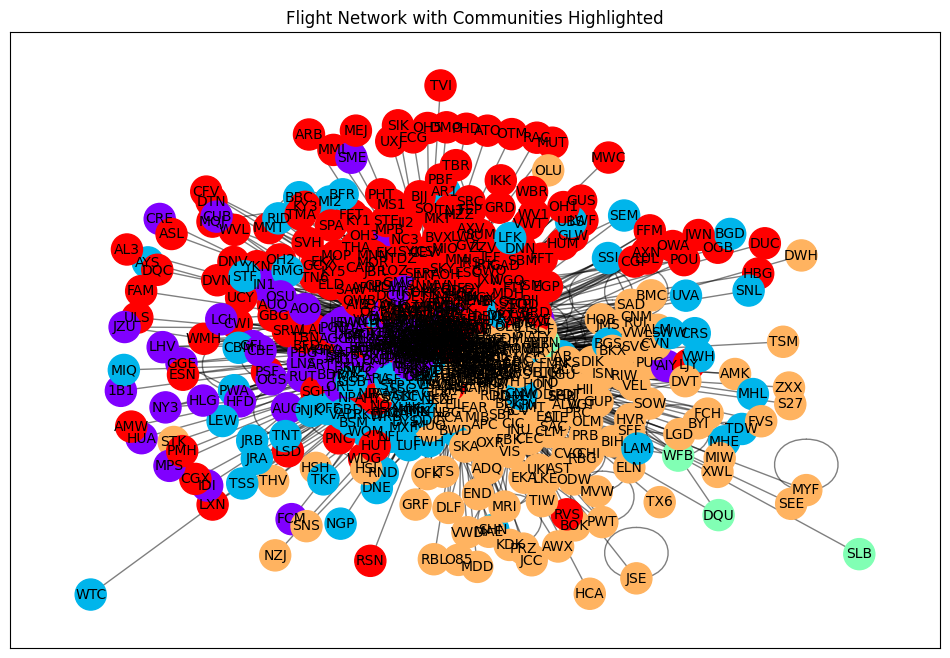

Total Communities: 5
Communities: {0: ['RKD', 'PBG', 'RUT', 'TMB', 'GGE', 'NY3', 'IDI', 'CKB', 'FXE', 'LNS', 'CHO', 'HSV', 'BWI', 'BDL', 'MDT', 'XXW', 'CMH', 'FLO', 'BKW', 'DCA', 'RDG', 'NZC', 'AIY', 'AHN', 'SME', 'ITH', 'VLD', 'ROA', 'ILM', 'PWM', 'ERI', 'AUG', 'GSP', 'PGV', 'BKL', 'BHM', 'AZO', 'CVG', 'UCA', 'AVL', 'ORH', 'FCM', 'TTN', 'TYS', 'MYR', 'GFL', 'LCK', 'CHA', 'CHS', 'ROC', '1B1', 'LHV', 'BQK', 'HFD', 'MPB', 'LYH', 'SBY', 'MGW', 'BTV', 'CRW', 'HLG', 'BGM', 'FLL', 'EYW', 'FAY', 'PHL', 'CLT', 'ARA', 'HVN', 'MHT', 'PVD', 'NIP', 'MPS', 'BOS', 'AND', 'BNA', 'HUA', 'CAE', 'PBI', 'ABY', 'PKB', 'EWR', 'IAD', 'LUK', 'PIT', 'MCO', 'EWN', 'CUB', 'DHN', 'HGR', 'ABE', 'TPA', 'JHW', 'ALB', 'OGS', 'ELM', 'IN1', 'YNG', 'GNV', 'GRB', 'CAK', 'JST', 'CRE', 'RIC', 'BFD', 'OAJ', 'SHD', 'LEX', 'APF', 'GSO', 'SCE', 'BDR', 'CSG', 'SAV', 'ACY', 'AOO', 'AGS', 'ILN', 'ORL', 'RDU', 'MCN', 'CBE', 'JAX', 'TLH', 'NQA', 'ISO', 'JZU', 'AVP', 'HKY', 'IPT', 'PFN', 'OSU', 'ATW', 'ART', 'BFM', 'BUF', 'PGD', 'S

In [51]:
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
def analyze_flight_network(flight_network, city1, city2):
    """
    Analyze the flight network to identify communities, calculate modularity, and check city connectivity.

    Parameters:
        flight_network (list of tuples): Each tuple represents a flight connection (city_a, city_b).
        city1 (str): The first city to check community membership.
        city2 (str): The second city to check community membership.

    Returns:
        dict: Contains the number of communities, the cities in each community, and connectivity info.
    """
    # Create a graph from the flight network
    G =flight_network.to_undirected()

    # Perform community detection using Louvain method
    partition = community_louvain.best_partition(G)

    # Calculate modularity
    modularity = community_louvain.modularity(partition, G)

    # Group cities by communities
    communities = {}
    for city, comm in partition.items():
        communities.setdefault(comm, []).append(city)

    # Check if city1 and city2 belong to the same community
    same_community = partition.get(city1) == partition.get(city2)

    # Visualize the graph with communities highlighted
    pos = nx.spring_layout(G, seed=42)  # Layout for consistent plotting
    plt.figure(figsize=(12, 8))

    # Assign colors to communities
    colors = [partition[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.rainbow, node_color=colors)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    plt.title("Flight Network with Communities Highlighted")
    plt.show()

    # Prepare output
    output = {
        "total_communities": len(communities),
        "communities": communities,
        "same_community": same_community,
        "modularity": modularity
    }

    return output


result = analyze_flight_network(G, 'TVI', 'UVA')
print("Total Communities:", result["total_communities"])
print("Communities:", result["communities"])
print(f"Do TVI and UVA belong to the same community?", result["same_community"])
print("Modularity:", result["modularity"])


The flight network has been partitioned in 46 communities.
+-------------+--------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

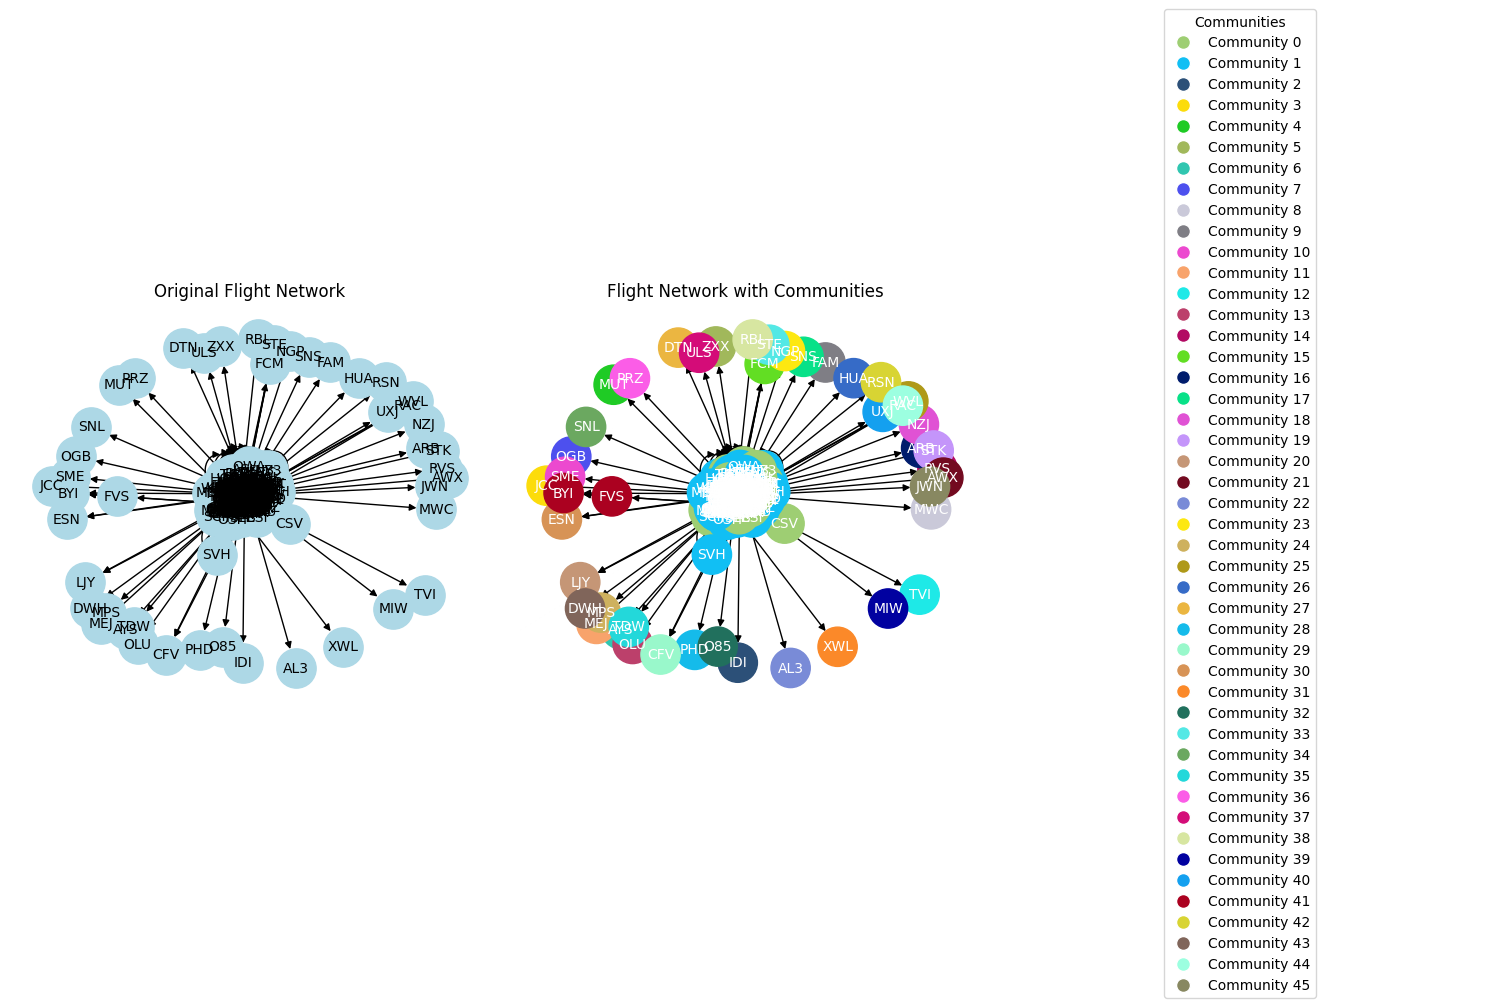

Are NIP and RKD in the same community? True


In [125]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import random

def analyze_flight_network(network, c1, c2):
    """
    Analyze the flight network, identify communities, visualize identified communities and check whether c1 and c2 belong to the same community.
    Args:
        network (CustomDiGraph): The flight network graph.
        c1 (str): Name of the first city.
        c2 (str): Name of the second city.
    """

    #Louvain-inspired community detection
    def custom_louvain_algorithm(network):
        # Total weight of edges (assuming unweighted network, each edge counts as 1)
        total_weight = network.num_edges()
        # Initialize communities: each node starts in its own community
        communities = {node: {node} for node in network.get_nodes()}
       # Track which community each node belongs to
        node_to_community = {node: node for node in network.get_nodes()}

        def move_node(node):
            # Track the current community of the node
            current_community = node_to_community[node]
            # Count the weights of edges connecting the node to each community
            community_weights = Counter()

            # Iterate through the neighbors of the node
            for neighbor in network.get_neighbors(node):
                # Get the community of the neighbor
                neighbor_community = node_to_community[neighbor]
                # Increment the weight of the connection to this community
                community_weights[neighbor_community] += 1

            # Variables to track the best gain and the corresponding community
            best_gain = 0
            best_community = current_community

            # Evaluate modularity gain for moving the node to neighboring communities
            for target_community, edge_weight in community_weights.items():
                if target_community != current_community:
                    #Calculate the total degree of nodes in the target community
                    total_degree = sum(network.out_degree(u) for u in communities[target_community])
                    #Get the out-degree of the current node
                    current_degree = network.out_degree(node)

                    # Compute the modularity gain for moving the node
                    gain = (edge_weight / total_weight) - (current_degree * total_degree) / (2 * total_weight ** 2)
                    # Update the best gain and community if the gain is greater
                    if gain > best_gain:
                        best_gain = gain
                        best_community = target_community

            # Move the node to the best community if there's a positive gain
            if best_community != current_community:
                #Remove the node from its current community
                communities[current_community].remove(node)
                #Add the node to the new community
                communities[best_community].add(node)
                #Update the mapping of the node to its new community
                node_to_community[node] = best_community

        # Perform 10 iterations to refine communities, a fixed number of iterations is used, since in most of cases, the algorithm can converge within this number
        for _ in range(10):
            for node in network.get_nodes():
                move_node(node)

        #Aggregate nodes into final communities
        aggregated_communities = defaultdict(set)
        for node, community in node_to_community.items():
            aggregated_communities[community].add(node)

        # Reorder community key 
        renamed_communities = {i: nodes for i, nodes in enumerate(aggregated_communities.values())}
        return renamed_communities


    #Identify communities
    communities = custom_louvain_algorithm(network)

    #Check if city1 and city2 belong to the same community
    city1_community, city2_community = None, None

    for community_id, nodes in communities.items():
        if c1 in nodes:
            city1_community = community_id
        if c2 in nodes:
            city2_community = community_id

    same_community = city1_community == city2_community



    # Visualize the graph
    def visualize_graph(graph, communities):
        nx_graph = graph.to_networkx_digraph()
        pos = nx.spring_layout(nx_graph)

        #Original graph
        plt.figure(figsize=(15, 8))

        plt.subplot(1, 3, 1)
        nx.draw(
            nx_graph, pos, with_labels=True, node_color="lightblue", edge_color="black",
            node_size=800, font_size=10, font_color="black"
        )
        plt.title("Original Flight Network")

        # Partitioned graph
        plt.subplot(1, 3, 2)
        # Assign a unique random color to each community
        community_colors = {community_id: "#%06x" % random.randint(0, 0xFFFFFF) for community_id in communities}
        node_colors = [community_colors[community_id] for node in nx_graph.nodes() for community_id, nodes in communities.items() if node in nodes]

        nx.draw(
            nx_graph, pos, with_labels=True, node_color=node_colors, edge_color="black",
            node_size=800, font_size=10, font_color="white"
        )
        plt.title("Flight Network with Communities")

        # Legend
        plt.subplot(1, 3, 3)
        plt.axis('off')
        legend_handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"Community {community_id}")
            for community_id, color in community_colors.items()
        ]
        plt.legend(handles=legend_handles, loc='center', title="Communities")

        plt.tight_layout()
        plt.show()



    #Print results
    print(f"The flight network has been partitioned in {len(communities)} communities.")

    community_list = []
    for key, values in communities.items():
        community_list.append({"Community Number": key, "Number of cities": len(values), "Cities": ", ".join(values)})
    community_df = pd.DataFrame(community_list)
    # Convert DataFrame to a tabular string format
    tabular_view = tabulate(community_df, headers="keys", tablefmt="grid", showindex=False)
    print(tabular_view)

    visualize_graph(graph, communities)
    print(f"Are {c1} and {c2} in the same community?", same_community)




analyze_flight_network(flight_network, "NIP", "RKD")







